# Review lại luồng hoạt động của bài báo

## Problem 1: Mô hình hóa
MDP áp dụng lý thuyết cho dữ liệu tuần tự (liên quan theo thời gian, như việc chơi cờ, lái xe,...), còn dữ liệu phân cụm gần như iid. Việc áp dụng MDP cho iid maybe ko hợp lý.


- Trong Clusterung thì k có khái niệm `future reward`, do đó equation (1) :  $J = E[Σ γ^t * r_{t+1}]$ tác giả redefine lại thành sample-average weight (đoạn này rất cấn, cám giác như biến cluster -> RL xong từ RL lại thành Cluster, kiểu tác giả chỉ dùng RL để tạo hàm mục tiêu và framework, còn k dùng lý thuyết của rl để giải.)

## Problem 2: Đóng góp phân phối khoảng cách

Trong bài báo `Unsupervised Deep Embedding for Clustering Analysis` - 2016, các tác giả đã sử dụng Phân phối T student với freedom = 1 để đo khoảng cách.

Following van der Maaten & Hinton (2008) we use the Stu
dent’s t-distribution as a kernel to measure the similarity
between embedded point zi and centroid µj:
EQUATION
(1)
where $zi = fθ(xi) ∈ Z$ corresponds to $xi ∈ X$ after em
bedding, **$α$ are the degrees of freedom of the Student’s t
distribution** and $qij$ can be interpreted as the probability
of assigning sample $i$ to cluster $j$ (i.e., a soft assignment).
Since we cannot cross-validate α on a validation set in the
unsupervised setting, and learning it is superfluous (van der
Maaten, 2009), **we let $α = 1$ for all experiments**

Bài báo này đưa ra innovation là Caunchy cho đo khoẳng cách `heavy-tailed property can preserve manifold structures`, nhưng thật ra chỉ là t-student với df = 1.

Nghĩa là tác giả dùng lại thí nghiệm của các tác giả trước đó, xong nhận đó là đóng góp lựa chọn Caunchy distribution, thật ra là đặt tên lại :v



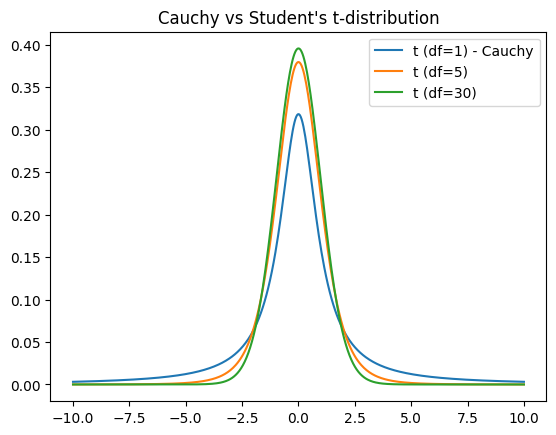

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, cauchy
x = np.linspace(-10, 10, 500)
plt.plot(x, t.pdf(x, df=1), label='t (df=1) - Cauchy')
plt.plot(x, t.pdf(x, df=5), label='t (df=5)')
plt.plot(x, t.pdf(x, df=30), label='t (df=30)')
plt.legend()
plt.title("Cauchy vs Student's t-distribution")
plt.show()

## Problem 3: Xác suất quyết định
Tác giả k dùng xác xuất thật mà có viết như này

`In such a manner, the reinforcement clustering gets rid of the probabilistic
constraint and utilizes the absolute divergencies of data struc
tures in fitting the decision distribution, which ensures accurate
measurements of structure discrepancies in learning an adaptive
clustering strategy`

Nghĩa là bài báo cũ (DEC) tính khoảng cách từ điểm $s$ tới tâm cụm $c_1$ tới $c_k$, sau đó tính xác suất bằng chia cho tổng khoảng cách (tính $d1,d2,...dk$, sau đó $p_i = [d_1/(d_1+d_2+...+d_k), d_2/(d_1+d_2+...+d_k), ..., d_k/(d_1+d_2+...+d_k)])$

Còn bài báo này tác giả tính $d1,d2,...dk$, sau đó áp dụng sigmoid để tính $p_i=s(d_1), s(d_2),...s(d_k)$ $s$ là hàm sigmoid. 

Nhìn chung thì phương pháp cũ người ta chuẩn hóa dể cho xác suất dương và tổng xác suất gắn 1 điểm vào các cụm bằng 1 (na ná softmax). Còn bài báo này tác giả trình bày rằng bỏ đi ràng buộc xác suất, tính toán dựa theo độ lớn khoảng cách tới mỗi tâm cụm. Do đó xác xuất này ko hẳn là xác suất (tổng không bằng 1).

Theo em hiểu thì ý tác giả là 1 điểm có thể rất xa các tâm cụm, nhưng khi biến đổi softmax  (hay chuẩn hóa xác suất nào đó) thì nó lại tương ứng với 1 đểm rất gần tâm cụm. Ví dụ như [1,2] và [100,200], sau khi biển đổi theo cách cũ thì đều có $p_i=[1/3, 2/3]$, nó bỏ qua đặc điểm về khoảng cách. Còn tác giả dùng softmax thì [1,2] thành [0.731, 0.881] và [100,200] thành [0.999, 0.999]. 

Nhưng sau đó tác giả sử dụng $p$ ngẫu nhiên thuộc (0,1) để ra quyết định khám phá/khai thác, cái này rất mất hợp lý khi $p$ không phải xác suất (nó không chạy từ 0 tới 1).


## Problem 4: Giải quyết nghịch lý khám phá, khai thác

Tuy nhiên nó vẫn có vấn đề rất lớn, sau khi tính $p$, tác giả xác định $y dựa trên $p$, nghĩa là tác giả muốn nếu điểm xa tâm thì có xác suất khám phá cao hơn, điểm gần tâm thì có xác suất khám phá ít hơn (giải quyết exploration-exploitation diplemma).

Nghe thì hợp lý nhưng để log ra thì không hợp lý, đi từng bước nhé.

0. Khoảng cách điểm tới tâm cụm (0.01 -> 100)
1. Tính khoảng cách dựa trên cauchy (0 -> 0.318)
2. Sigmoid để tạo p  **(0.50 -> 0.58) chênh lệch chưa tới 8%**
3. Khởi tạo p ngẫu nhiên (0,1)
4. Tính y dựa trên p


Như đã thấy trong khoảng giá trị xác suất chỉ nằm 0.5 tới 0.58, như vậy thì gấn như không phân biệt điểm xa gần **(1)**, và việc khai thác khám phá trở nên không hợp lý (không khác gì ngẫu nhiên, 1 điểm rất gần vẫn có thể gán xác suất khám phá tới tận 42%). **(2)**

In [7]:
import numpy as np

# Giả lập dữ liệu
z = np.array([0, 0])  # Điểm dữ liệu
clusters = np.array([
    [0.1, 0.1],   # Cluster gần
    [5.0, 5.0],   # Cluster xa
    [10.0, 10.0]  # Cluster rất xa
])

# Phương pháp trong bài báo
def paper_method(z, clusters):
    distances = np.sum((clusters - z)**2, axis=1)
    s = (1/np.pi) * (1 / (distances + 1))
    p = 1 / (1 + np.exp(-s))
    return p, s



p_paper, s = paper_method(z, clusters)


print("=== PHƯƠNG PHÁP TRONG BÀI BÁO ===")
print(f"Similarities: {s}")
print(f"'Probabilities': {p_paper}")
print(f"Tổng: {p_paper.sum():.3f} ❌\n")




=== PHƯƠNG PHÁP TRONG BÀI BÁO ===
Similarities: [0.31206852 0.00624137 0.00158363]
'Probabilities': [0.57739008 0.50156034 0.50039591]
Tổng: 1.579 ❌




---

## **TẠI SAO TÁC GIẢ LẠI LÀM VẬY?**

Tác giả viết: *"gets rid of the probabilistic constraint and utilizes the absolute divergencies"*

**Phân tích:**
- ❌ Sigmoid KHÔNG giữ được "absolute divergencies" - nó nén mọi thứ vào [0.5, 0.6]
- ❌ "Loại bỏ probabilistic constraint" = vi phạm toán học cơ bản
- ✓ Có thể tác giả muốn tránh vanishing gradient của softmax
- ✓ Nhưng cách này làm **mất tính phân biệt**

---

## **KẾT LUẬN BẰNG SỐ LIỆU:**

### **1. Vấn đề "saturated sigmoid":**
- Sigmoid của số nhỏ (0-0.3) luôn cho output ~0.5

### **2. Không phải xác suất:**
- Tổng = 1.58 thay vì 1.0
- Vi phạm axiom xác suất cơ bản

### **3. Giải thích vì sao vẫn chạy:**
```
Dù p_ij gần như random (~0.5), nhưng:
- Gradient vẫn có chiều hướng (dù yếu)
- Reconstruction loss **Lrec** làm chủ đạo
- Network học từ autoencoder, không phải từ "RL"
```

### **4. Thực chất:**
Đây là **deep autoencoder clustering** với một regularization term kỳ lạ, **KHÔNG phải reinforcement learning**.